In [1]:
import sys
sys.path.append("../LocalGraphClustering/")
import localgraphclustering as lgc
from localgraphclustering.find_clusters import semisupervised_learning_with_improve,semisupervised_learning
from collections import Counter,defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Citeseer dataset

In [2]:
rptr = open("dataset/citeseer/citeseer.content","r")
lines = rptr.readlines()
rptr.close()

ids = {}
labels = {}
clusters = defaultdict(list)
nnodes = 0
for i,line in enumerate(lines):
    tmp = line.replace("\n","").split("\t")
    labels[i] = tmp[-1]
    ids[tmp[0]] = i
    nnodes += 1
    clusters[tmp[-1]].append(i)

rptr = open("dataset/citeseer/citeseer.cites","r")
lines = rptr.readlines()
rptr.close()

ei,ej = [],[]
for line in lines:
    tmp = line.replace("\n","").split("\t")
    if tmp[0] not in ids:
        ids[tmp[0]] = nnodes
        nnodes += 1
    if tmp[1] not in ids:
        ids[tmp[1]] = nnodes
        nnodes += 1
    ei.append(ids[tmp[0]])
    ej.append(ids[tmp[1]])

g = lgc.GraphLocal()
g.list_to_gl(ei,ej,[1.0]*len(ei))
g.connected_components()
largest_component= set(np.nonzero(g.components == Counter(g.components).most_common()[0][0])[0])
g_copy = g.largest_component()
clusters_copy = defaultdict(list)
nnodes = 0
for i in range(g._num_vertices):
    if i in largest_component:
        if i in labels:
            clusters_copy[labels[i]].append(nnodes)
        else:
            clusters_copy["unknown"].append(nnodes)
        nnodes += 1

There are  438  connected components in the graph
There are  438  connected components in the graph


../LocalGraphClustering/localgraphclustering/GraphLocal.py:621: UserWarning:

The graph has multiple (438) components, using the largest with 2120 / 3327 nodes



In [3]:
label = "Agents"
cls = clusters_copy[label]

print(g_copy.compute_conductance(cls))

0.20696452036793692


## semi-supervised learning using l1reg followed by flow method

In [4]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":rho,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-10,
                "iterations":100000,
                "cpp":True,
                "delta":0.1} for rho in np.geomspace(1.0e-3, 1.0e-18, 20, endpoint=True)]

In [5]:
records = semisupervised_learning_with_improve(g_copy,cls,kwargs_list,nprocs=10)

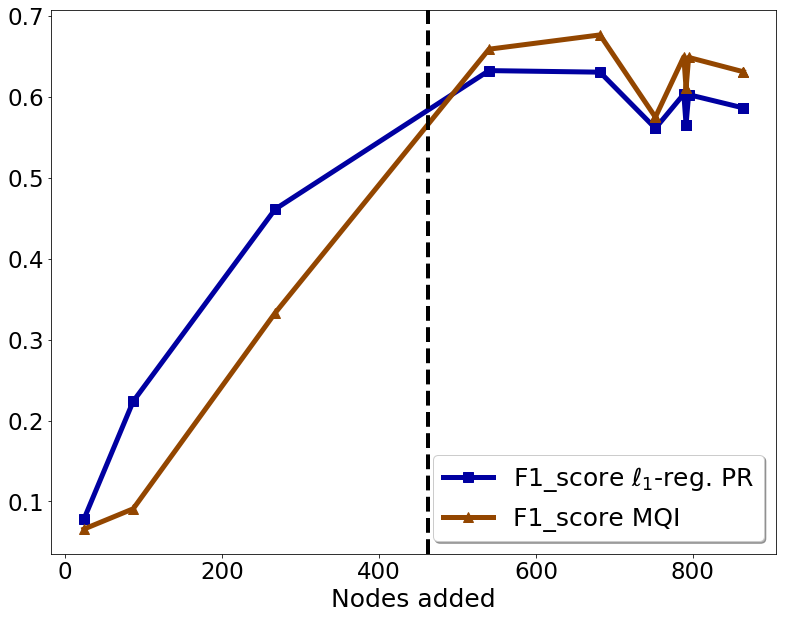

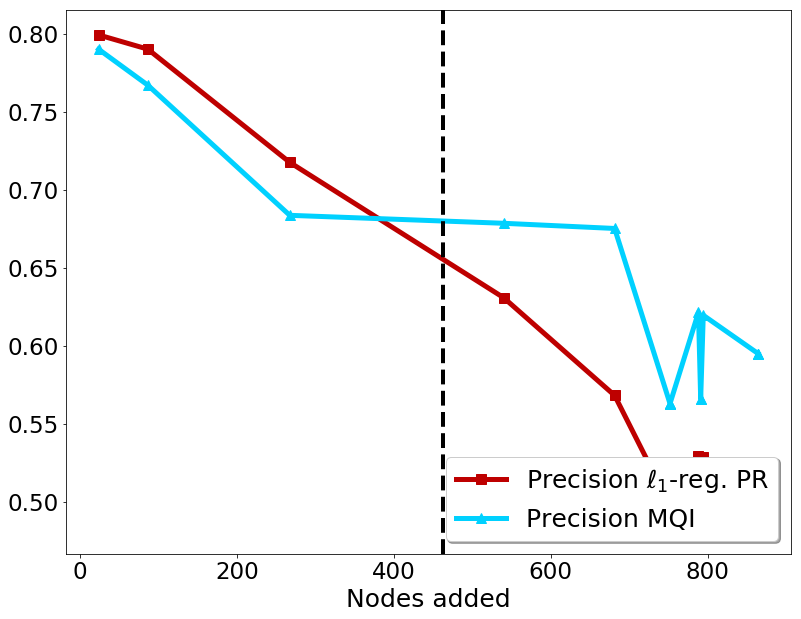

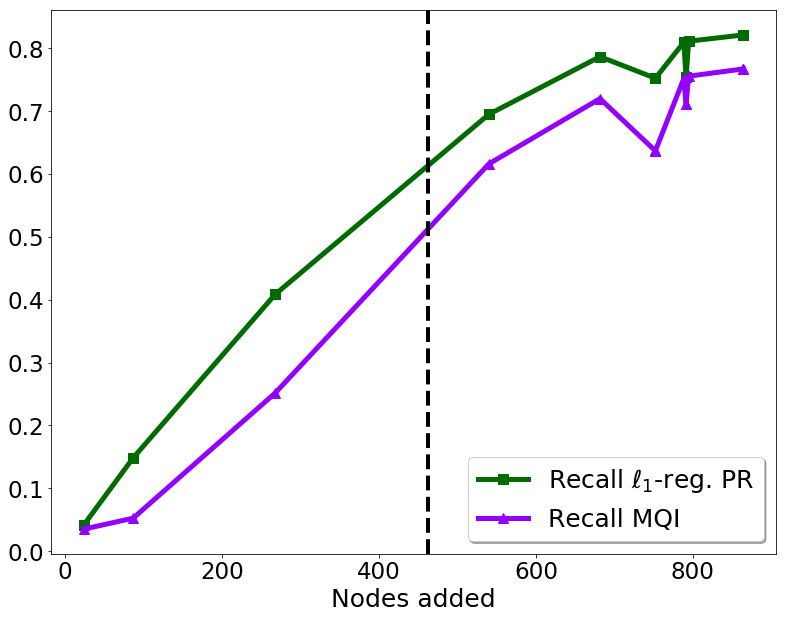

In [6]:
x = np.array([i[0] for i in records["input_size_all"]])
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["mqi_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["mqi_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["mqi_RC_all"]])

sorted_indices = np.argsort(x)
x = x[sorted_indices]
y1 = y1[sorted_indices]
y2 = y2[sorted_indices]
y3 = y3[sorted_indices]
y4 = y4[sorted_indices]
y5 = y5[sorted_indices]
y6 = y6[sorted_indices]

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

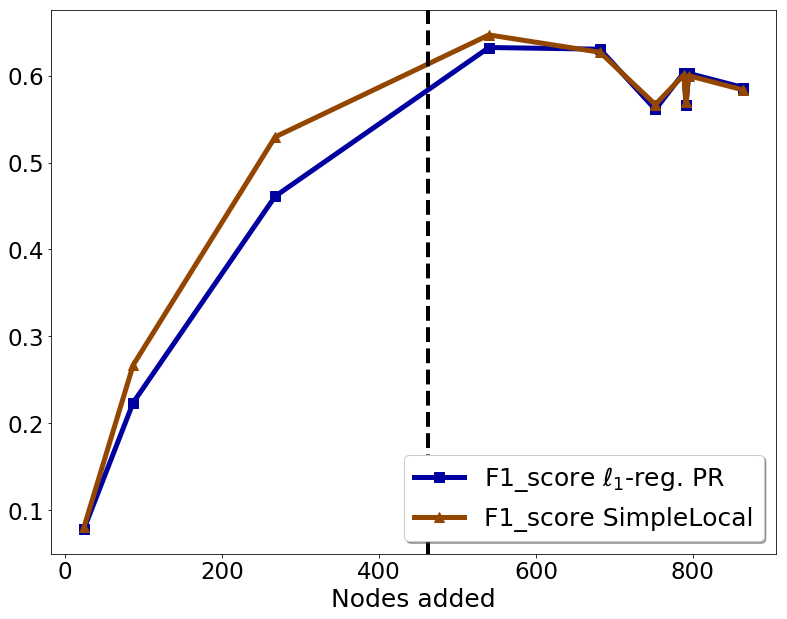

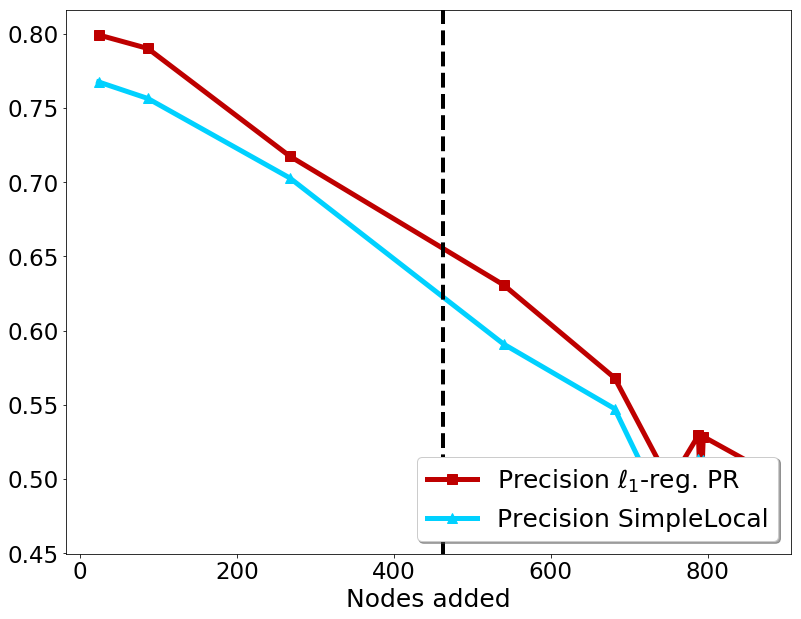

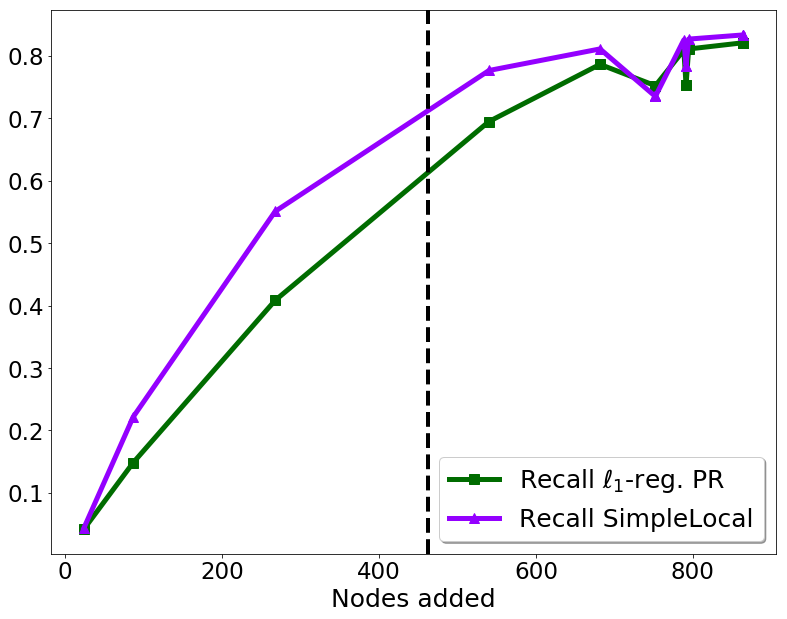

In [7]:
x = np.array([i[0] for i in records["input_size_all"]])
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["sl_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["sl_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["sl_RC_all"]])

sorted_indices = np.argsort(x)
x = x[sorted_indices]
y1 = y1[sorted_indices]
y2 = y2[sorted_indices]
y3 = y3[sorted_indices]
y4 = y4[sorted_indices]
y5 = y5[sorted_indices]
y6 = y6[sorted_indices]

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

## semi-supervised learning using subset of target cluster as seed nodes

In [8]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-10,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-8,
                "iterations":100000,
                "cpp":True,
                "delta":0.001,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [9]:
records = semisupervised_learning(g_copy,cls,kwargs_list,nprocs=10)

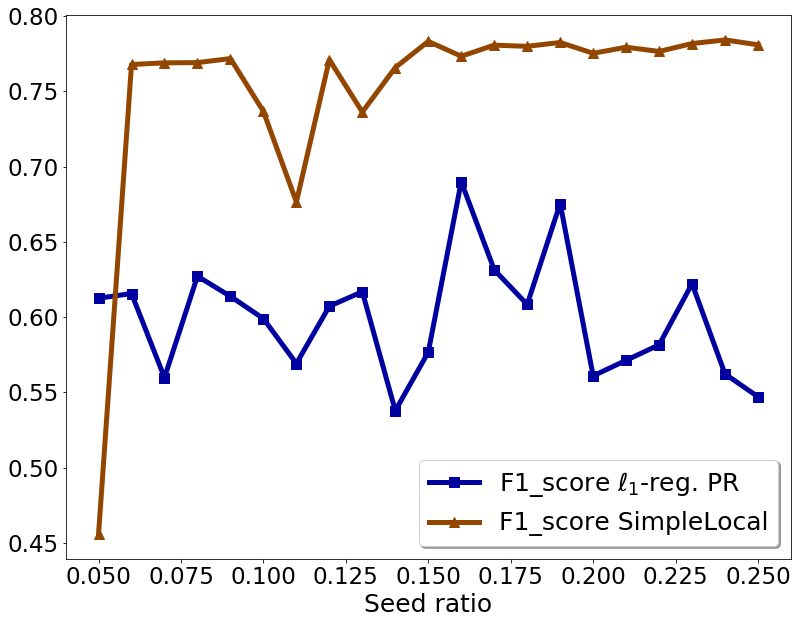

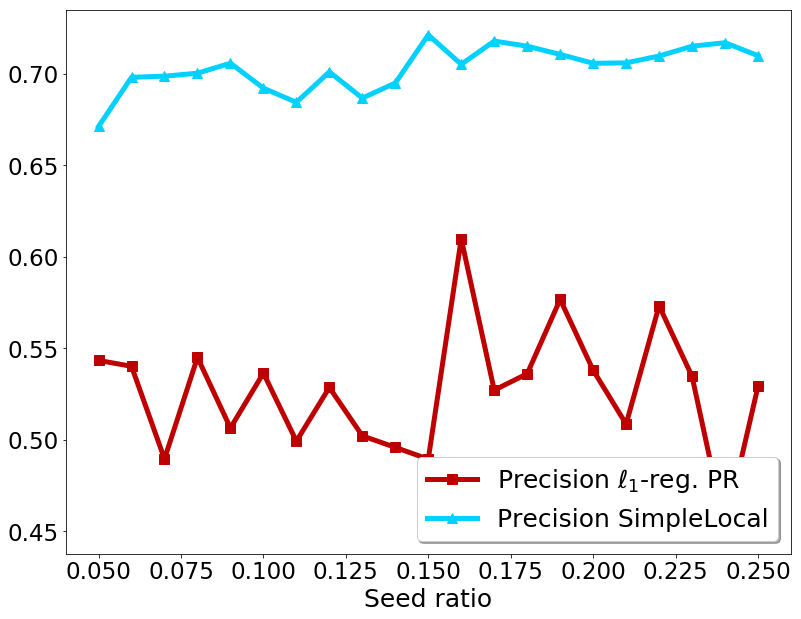

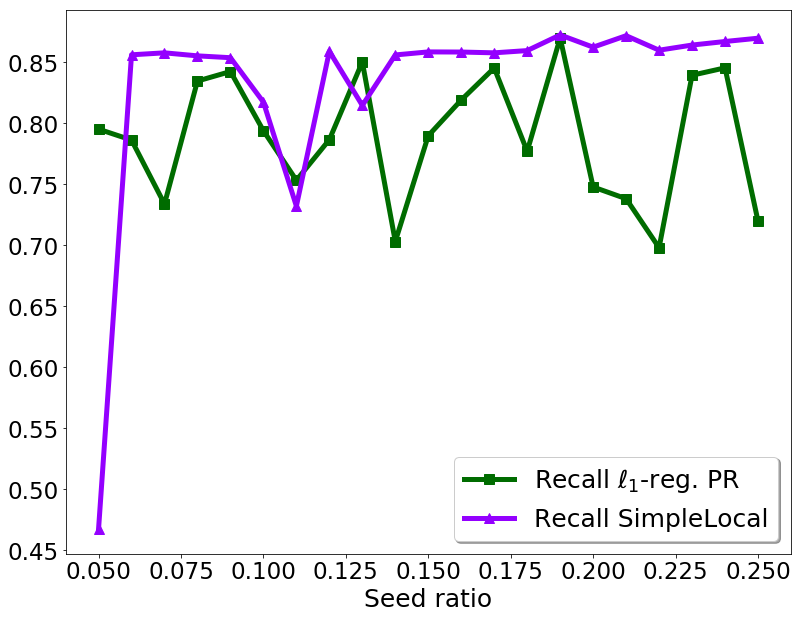

In [10]:
x = 0.01*np.array(range(5,26))
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["sl_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["sl_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["sl_RC_all"]])

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# Cora citation dataset

In [11]:
import sys
sys.path.append("../LocalGraphClustering/")
import localgraphclustering as lgc
from collections import Counter,defaultdict
import numpy as np

rptr = open("dataset/cora/cora.content","r")
lines = rptr.readlines()
rptr.close()

ids = {}
labels = {}
clusters = defaultdict(list)
nnodes = 0
for i,line in enumerate(lines):
    tmp = line.replace("\n","").split("\t")
    labels[i] = tmp[-1]
    ids[tmp[0]] = i
    nnodes += 1
    clusters[tmp[-1]].append(i)

rptr = open("dataset/cora/cora.cites","r")
lines = rptr.readlines()
rptr.close()

ei,ej = [],[]
for line in lines:
    tmp = line.replace("\n","").split("\t")
    if tmp[0] not in ids:
        ids[tmp[0]] = nnodes
        nnodes += 1
    if tmp[1] not in ids:
        ids[tmp[1]] = nnodes
        nnodes += 1
    ei.append(ids[tmp[0]])
    ej.append(ids[tmp[1]])

g = lgc.GraphLocal()
g.list_to_gl(ei,ej,[1.0]*len(ei))
g.connected_components()
largest_component= set(np.nonzero(g.components == Counter(g.components).most_common()[0][0])[0])
g_copy = g.largest_component()
clusters_copy = defaultdict(list)
nnodes = 0
for i in range(g._num_vertices):
    if i in largest_component:
        if i in labels:
            clusters_copy[labels[i]].append(nnodes)
        else:
            clusters_copy["unknown"].append(nnodes)
        nnodes += 1

There are  78  connected components in the graph
There are  78  connected components in the graph


../LocalGraphClustering/localgraphclustering/GraphLocal.py:621: UserWarning:

The graph has multiple (78) components, using the largest with 2485 / 2708 nodes



In [12]:
label = "Genetic_Algorithms"
cls = clusters_copy[label]

print(g_copy.compute_conductance(cls))

0.09271523178807947


## semi-supervised learning using l1reg followed by flow method

In [13]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":rho,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-10,
                "iterations":100000,
                "delta":0.1,
                "cpp":True} for rho in np.geomspace(1.0e-3, 1.0e-18, 20, endpoint=True)]

In [14]:
records = semisupervised_learning_with_improve(g_copy,cls,kwargs_list,nprocs=10)

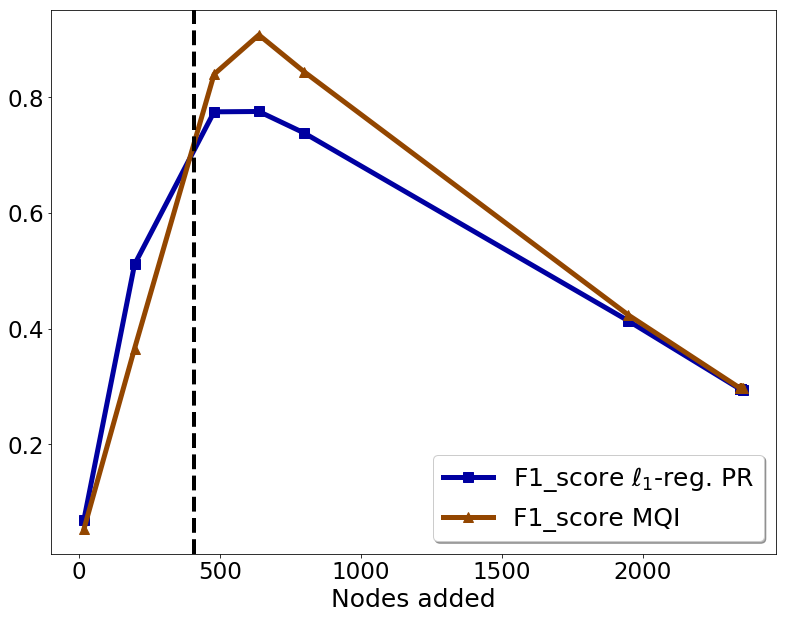

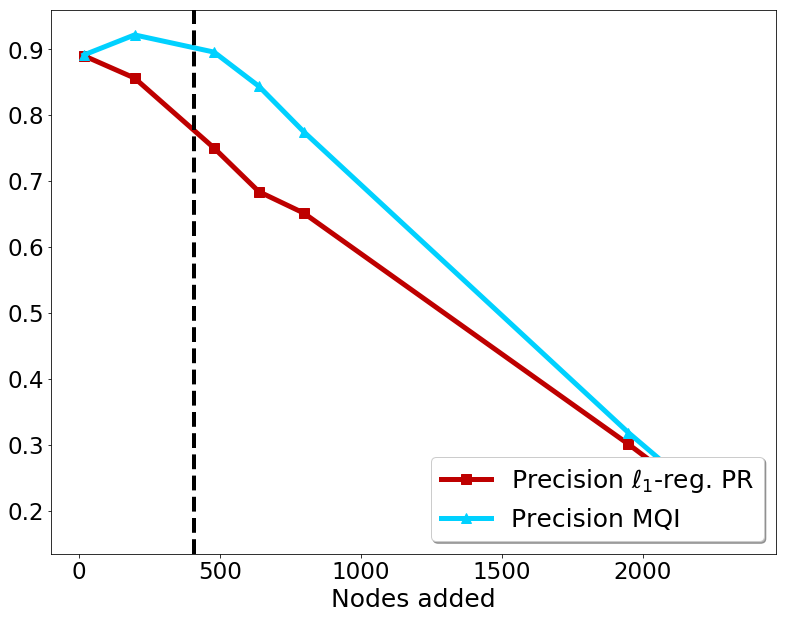

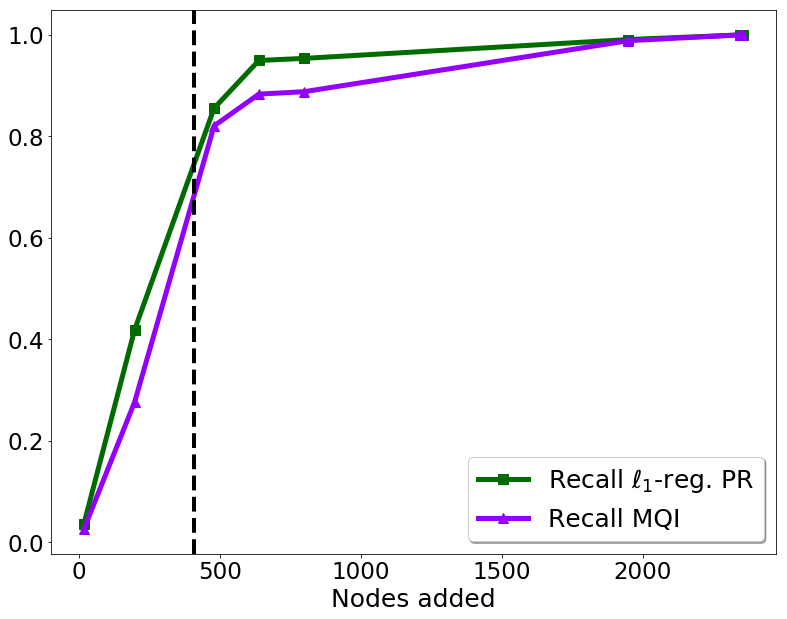

In [15]:
x = np.array([i[0] for i in records["input_size_all"]])
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["mqi_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["mqi_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["mqi_RC_all"]])

sorted_indices = np.argsort(x)
x = x[sorted_indices]
y1 = y1[sorted_indices]
y2 = y2[sorted_indices]
y3 = y3[sorted_indices]
y4 = y4[sorted_indices]
y5 = y5[sorted_indices]
y6 = y6[sorted_indices]

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

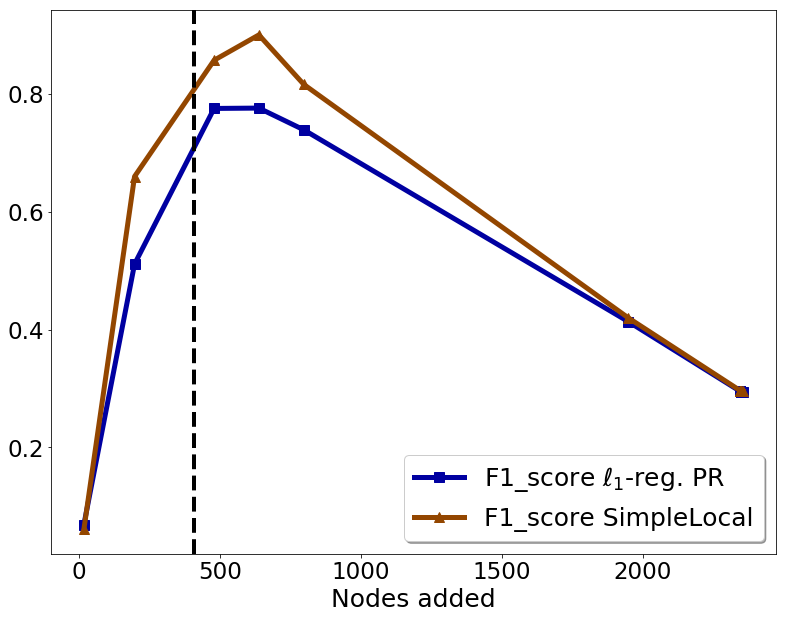

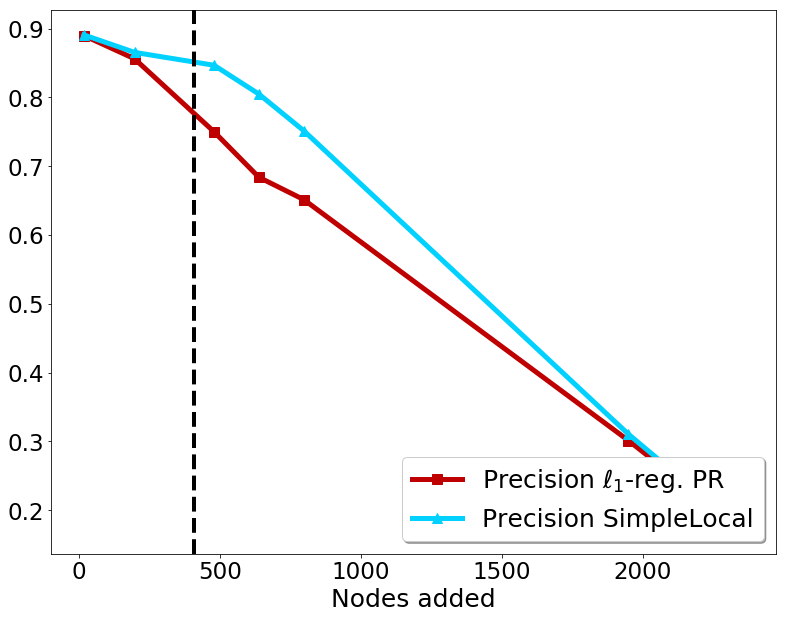

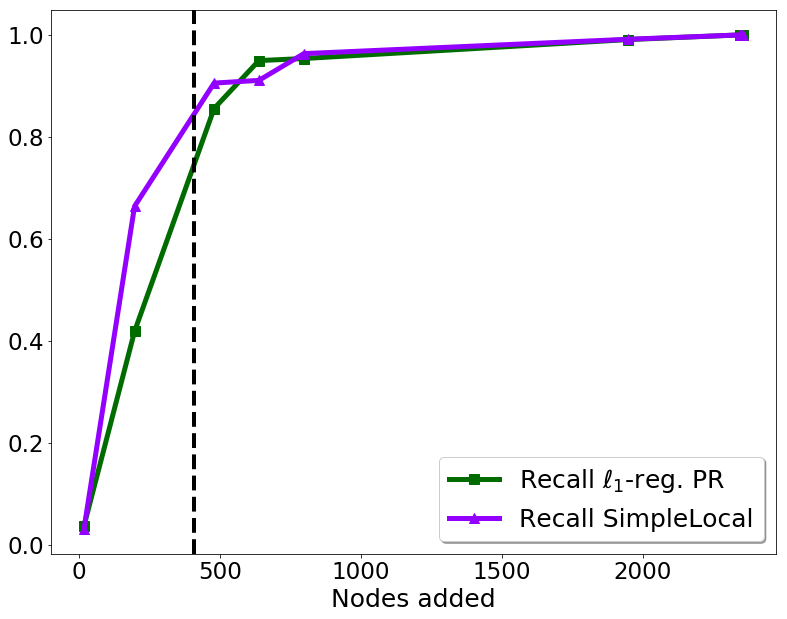

In [16]:
x = np.array([i[0] for i in records["input_size_all"]])
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["sl_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["sl_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["sl_RC_all"]])

sorted_indices = np.argsort(x)
x = x[sorted_indices]
y1 = y1[sorted_indices]
y2 = y2[sorted_indices]
y3 = y3[sorted_indices]
y4 = y4[sorted_indices]
y5 = y5[sorted_indices]
y6 = y6[sorted_indices]

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

## semi-supervised learning using subset of target cluster as seed nodes

In [17]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-10,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-8,
                "iterations":100000,
                "cpp":True,
                "delta":0.001,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [18]:
records = semisupervised_learning(g_copy,cls,kwargs_list,nprocs=10)

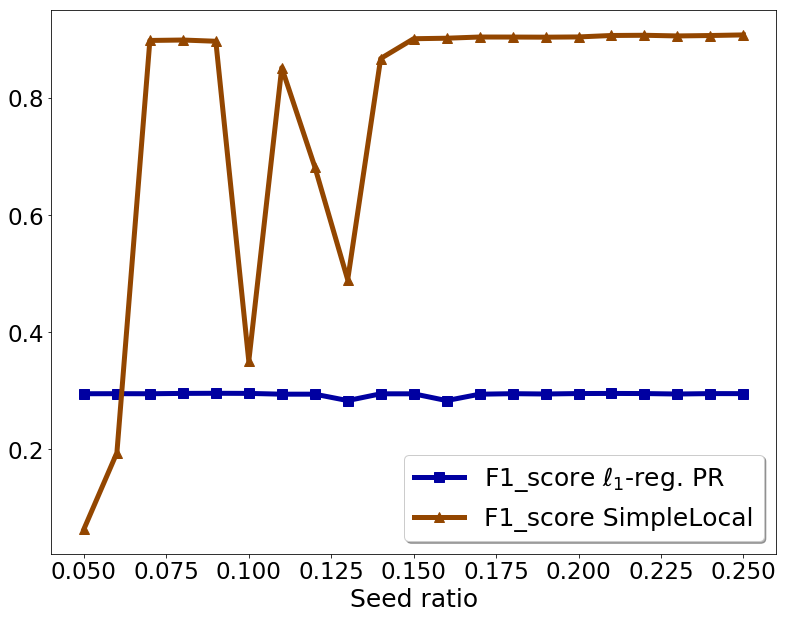

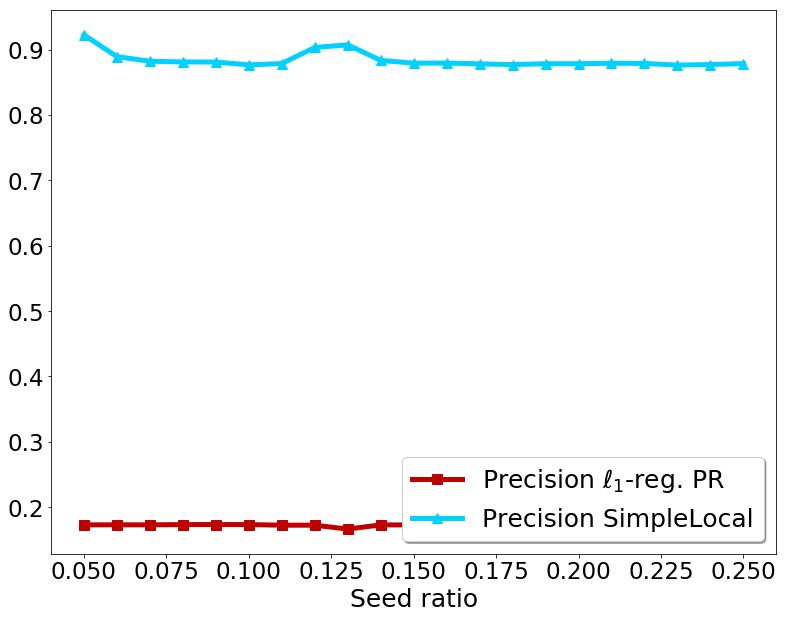

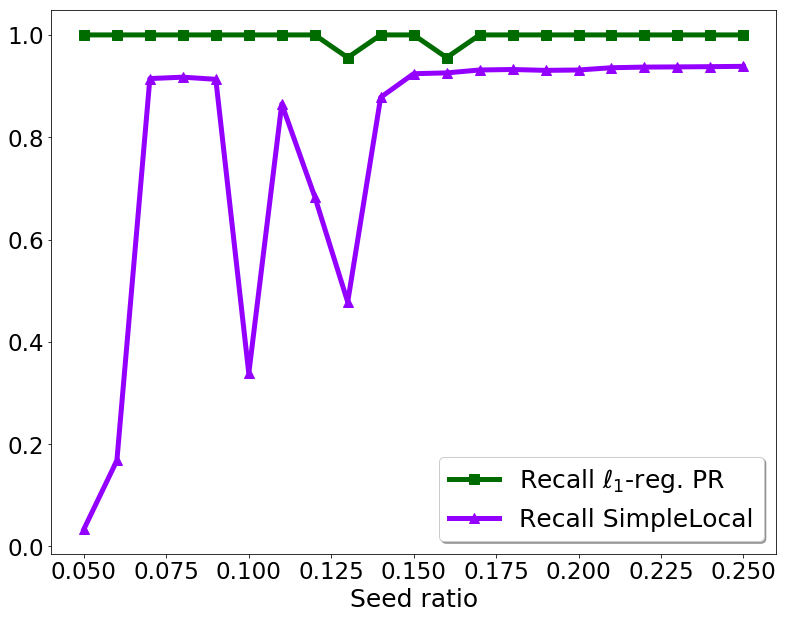

In [19]:
x = 0.01*np.array(range(5,26))
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["sl_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["sl_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["sl_RC_all"]])

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# MNIST knn network

In [20]:
import numpy as np
import mnist
import scipy.misc

images = mnist.train_images()
labels = mnist.train_labels()

In [21]:
image_data = np.zeros((images.shape[0],images.shape[1]*images.shape[2]),dtype=np.float32)

In [22]:
for i,im in enumerate(images):
    image_data[i,:] = (im.astype("float32")/255).flatten()

In [23]:
import pickle
rptr = open("dataset/MNIST_knn.p","rb")
A = pickle.load(rptr)
rptr.close()

A.eliminate_zeros()
A.data = np.exp(-1*(A.data)**2/4.0)

In [24]:
g = lgc.GraphLocal.from_sparse_adjacency(A)
clusters = defaultdict(list)
for i,l in enumerate(labels):
    clusters[l].append(i)
g.connected_components()
largest_component= set(np.nonzero(g.components == Counter(g.components).most_common()[0][0])[0])
g_copy = g.largest_component()
clusters_copy = defaultdict(list)
nnodes = 0
for i in range(g._num_vertices):
    if i in largest_component:
        clusters_copy[labels[i]].append(nnodes)
        nnodes += 1

There are  1  connected components in the graph
There are  1  connected components in the graph


In [25]:
label = 0
cls = clusters_copy[label]

print(g_copy.compute_conductance(cls))

0.002930593157533421


## semi-supervised learning using l1reg followed by flow method

In [33]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":rho,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-10,
                "iterations":20000,
                "delta":0.1,
                "cpp":True} for rho in np.geomspace(1.0e-3, 1.0e-18, 20, endpoint=True)]

In [34]:
records = semisupervised_learning_with_improve(g_copy,cls,kwargs_list,nprocs=20)

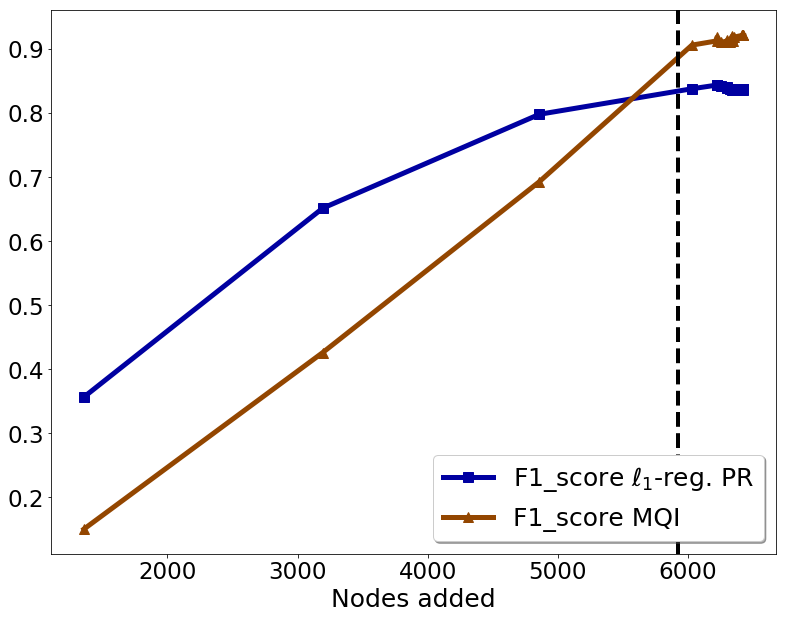

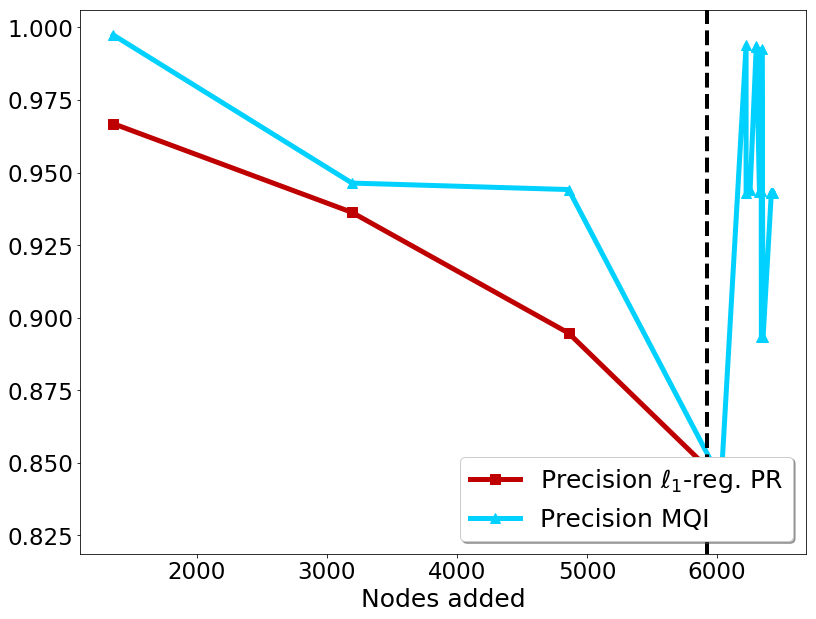

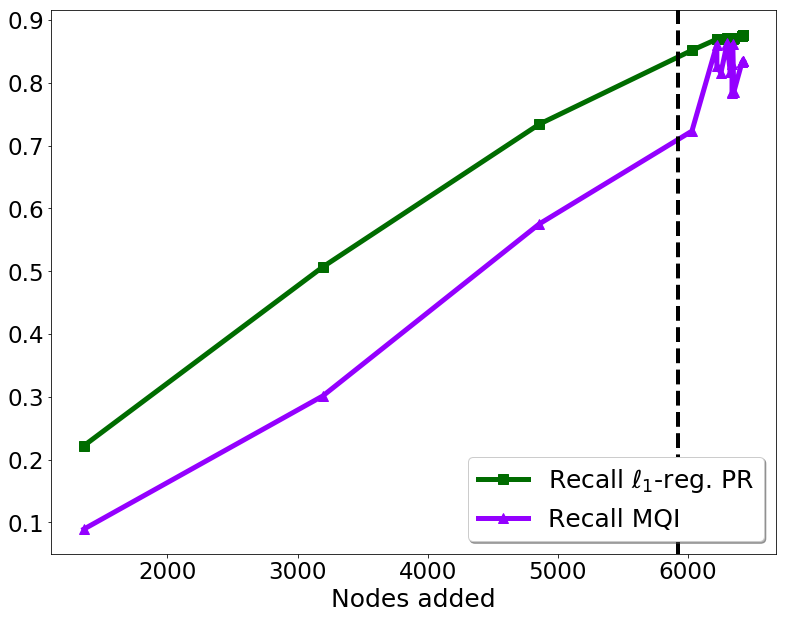

In [37]:
x = np.array([i[0] for i in records["input_size_all"]])
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["mqi_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["mqi_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["mqi_RC_all"]])

sorted_indices = np.argsort(x)
x = x[sorted_indices]
y1 = y1[sorted_indices]
y2 = y2[sorted_indices]
y3 = y3[sorted_indices]
y4 = y4[sorted_indices]
y5 = y5[sorted_indices]
y6 = y6[sorted_indices]

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

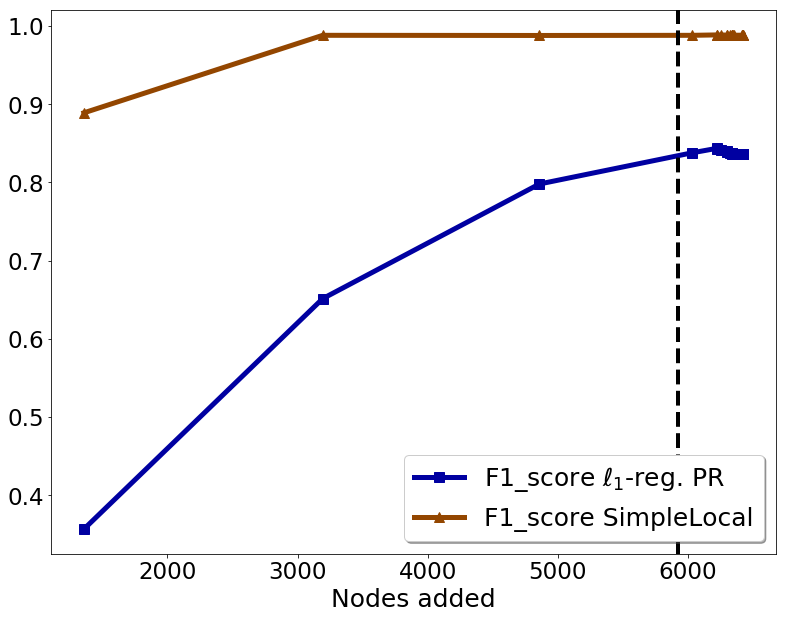

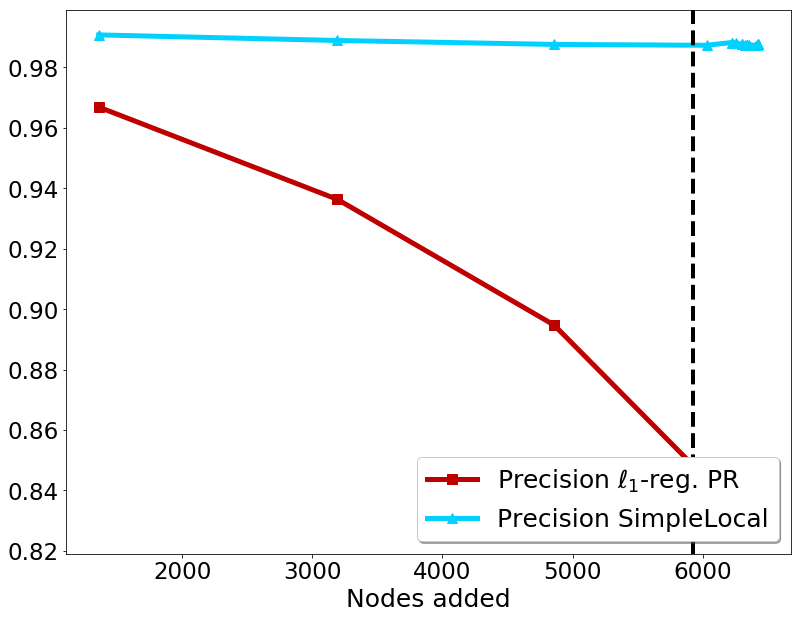

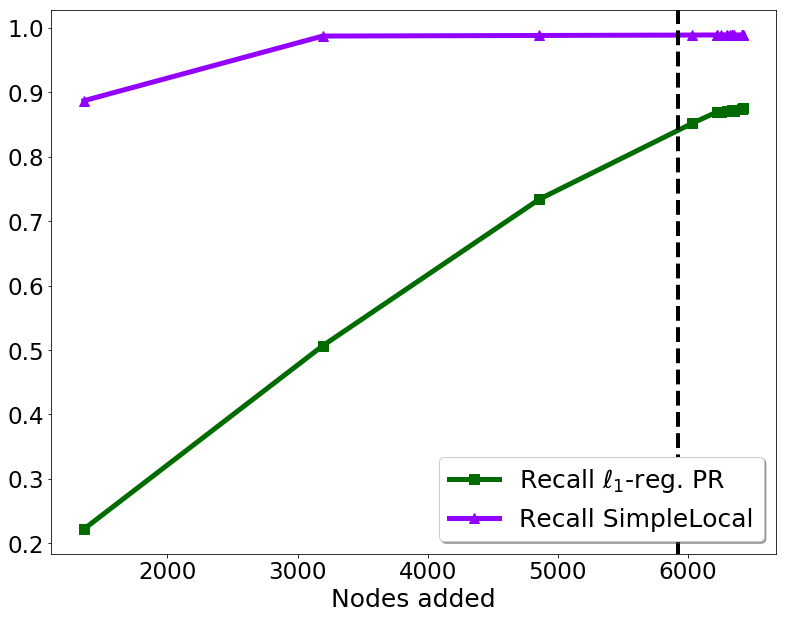

In [38]:
x = np.array([i[0] for i in records["input_size_all"]])
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["sl_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["sl_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["sl_RC_all"]])

sorted_indices = np.argsort(x)
x = x[sorted_indices]
y1 = y1[sorted_indices]
y2 = y2[sorted_indices]
y3 = y3[sorted_indices]
y4 = y4[sorted_indices]
y5 = y5[sorted_indices]
y6 = y6[sorted_indices]

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

## semi-supervised learning using subset of target cluster as seed nodes

In [30]:
kwargs_list = [{"method":"l1reg-rand",
                "alpha":0.1,
                "rho":1.0e-10,
                "normalize":False,
                "normalized_objective":False,
                "epsilon":1.0e-8,
                "iterations":100000,
                "cpp":True,
                "delta":0.1,
                "ratio":ratio} for ratio in 0.01*np.array(range(5,26))]

In [31]:
records = semisupervised_learning(g_copy,cls,kwargs_list,nprocs=21)

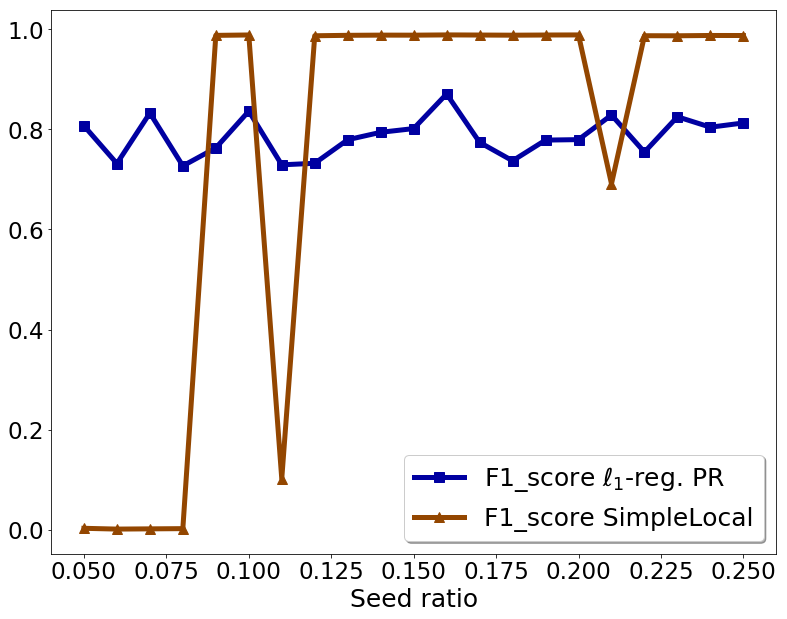

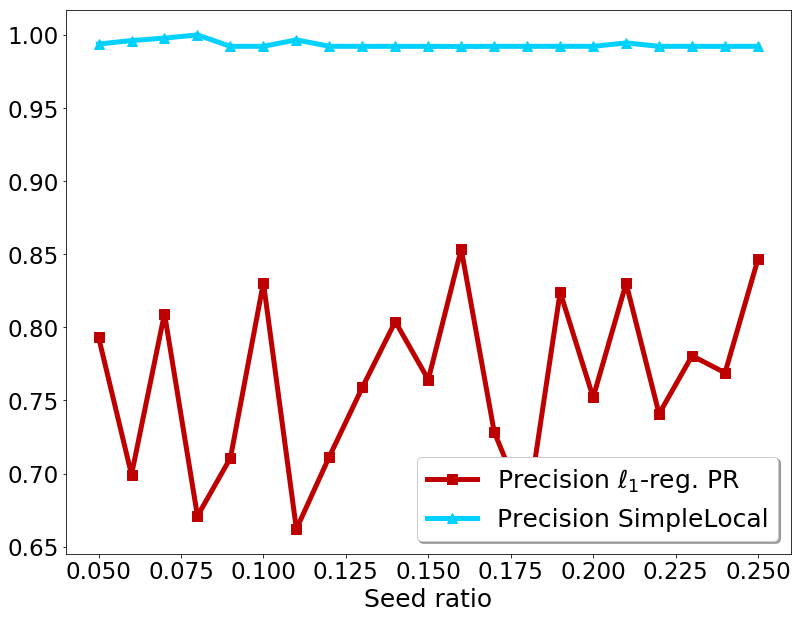

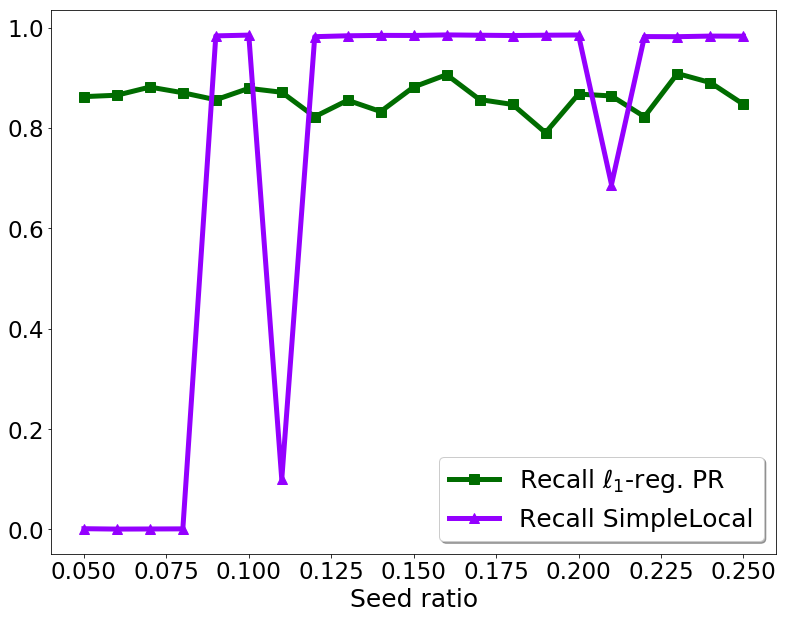

In [32]:
x = 0.01*np.array(range(5,26))
y1 = np.array([i[0] for i in records["l1reg_F1_all"]])
y2 = np.array([i[0] for i in records["sl_F1_all"]])
y3 = np.array([i[0] for i in records["l1reg_PR_all"]])
y4 = np.array([i[0] for i in records["sl_PR_all"]])
y5 = np.array([i[0] for i in records["l1reg_RC_all"]])
y6 = np.array([i[0] for i in records["sl_RC_all"]])

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(x, y1, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(x, y2, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y3, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(x, y4, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

f = plt.figure(figsize=(13, 10))

plt.plot(x, y5, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(x, y6, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
#plt.axvline(x=len(cls),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Seed ratio', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()